# Setting up environment and defining helper functions

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
import sys
print(sys.version)
print(spark.version)
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from itertools import compress 
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row

%pip install nltk -U
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [5]:
from google.cloud import storage

def list_blobs(bucket_name, folder_name):
    gcs_client = storage.Client()
    bucket = gcs_client.bucket(bucket_name)
    blobs = list(bucket.list_blobs(prefix=folder_name))

    for blob in blobs:
        print(blob.name + '\t' + str(blob.size))
        
        
# Reading data from open bucket, avaible to all students
bucket_read = 'msca-bdp-tweets'
folder_read = 'final_project'

# Saving results into individual bucket, students must update to their own bucket `msca-bdp-students-bucket` and use `CNET ID` as a folder prefix
bucket_write = 'msca-bdp-students-bucket'
folder_write = 'shared_data/kaitongh/filtered_dataset'

# Step 1: Loading the data

In [6]:
from google.cloud import storage

In [7]:
path = 'gs://msca-bdp-students-bucket/shared_data/kaitongh/filtered_dataset'

df = spark.read.parquet(path)

In [8]:
df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- tweet_id: long (nullable = true)
 |-- tweet_text: string (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- tweet_country: string (nullable = true)
 |-- tweet_location: string (nullable = true)
 |-- retweeted_status.retweet_count: long (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- retweeted: string (nullable = true)
 |-- favorite_count: long (nullable = true)
 |-- timestamp_ms: string (nullable = true)



In [26]:
df.count()

99100416

In [9]:
df.limit(3)

created_at,tweet_id,tweet_text,user_id,user_name,user_screen_name,user_location,user_description,tweet_country,tweet_location,retweeted_status.retweet_count,retweeted_from,retweeted,favorite_count
Mon Aug 08 20:25:...,1556738289050214405,i refuse to let m...,1515465417103491072,omgnotagain1,omgnotagain10,null,null,null,null,49,spinbop14,RT,0
Mon Aug 08 20:25:...,1556738289532637184,@rpsagainsttrump ...,1445137100282777761,Sam,Sam74243610,null,null,null,null,14,UROCKlive1,RT,0
Mon Aug 08 20:25:...,1556738292141510657,just imagine the ...,456450024,Murtala,Murtalaibin,Nigeria,@HumAngle_ Conf...,null,null,null,null,,0


22/12/04 01:41:08 WARN org.apache.spark.HeartbeatReceiver: Removing executor 12 with no recent heartbeats: 120896 ms exceeds timeout 120000 ms
22/12/04 01:41:08 WARN org.apache.spark.HeartbeatReceiver: Removing executor 9 with no recent heartbeats: 126982 ms exceeds timeout 120000 ms


# Step 2: Analysis

In [9]:
### select a smaller sample from the dataset for faster analysis
sub = df.sample(0.0002)

In [10]:
sub.limit(10)

created_at,tweet_id,tweet_text,user_id,user_name,user_screen_name,user_location,user_description,tweet_country,tweet_location,retweeted_status.retweet_count,retweeted_from,retweeted,favorite_count,timestamp_ms
Fri Jul 08 01:29:...,1545218514440654849,"""indiana is prepa...",16482183,Carrie,harleygold,"Indiana, USA",Biking somewhere....,null,null,76,allinwithchris,RT,0,1657243777271
Fri Apr 29 17:16:...,1520089652870492160,hey @ponterossomd...,1498431797914443780,Shelby,Shelby69453653,null,null,null,null,null,"ponterossoMD, I ...",,0,1651252589801
Fri Apr 29 17:17:...,1520089823096225792,with seoul’s ewha...,1299921064265420800,BLACKPINK IS THE ...,JisMalu,null,KIM JISOO ♠️,null,null,7020,Dior,RT,0,1651252630386
Thu Aug 04 12:09:...,1555163932335017988,glimpses of the s...,1505532038572482560,Tapaswini Parida,TapaswiniPari16,null,null,null,null,63,KIITUniversity,RT,0,1659614949674
Sat May 14 15:54:...,1525504810203717633,dear mr president...,20172321,𝐀𝐧𝐝𝐫𝐞𝐰 𝐖𝐞...,CircleReader,"Madison, Wisconsin","Human first, then...",null,null,827,Ethnography911,RT,0,1652543663918
Thu Sep 29 16:58:...,1575530495974440961,"@rosskneedeep no,...",4107298575,John Armistead,chiniakak,null,"Navy 1966-72, ret...",null,null,null,null,,0,1664470716838
Thu Jun 09 22:30:...,1535026657622478855,@pmynmnobody @mar...,1040947569122267141,Roxanne Hawes,RoxanneHawes,null,null,null,null,null,MarshaBlackburn @...,,0,1654813849250
Sun Jul 03 17:08:...,1543642943789142017,blessed and honor...,2800408669,KMKG JOE,joe_kmkg,"Jackson, MS",A ambitious young...,null,null,10,JaceWard_OLB,RT,0,1656868131955
Sat Apr 23 02:51:...,1517697728238985216,「the boy who bull...,1323620930480791552,タコ二ク,takoniku_,null,hello. 🏆🪐🎨💥,null,null,786,pompmaker1,RT,0,1650682310529
Tue Aug 16 19:01:...,1559616388884471811,@misskaahaani bec...,1352325615966449664,LeeTaeEul22,Eul22Lee,null,Being a little we...,null,null,null,null,,0,1660676498038


In [26]:
sub.count()

19786

In [10]:
df = df.withColumnRenamed('retweeted_status.retweet_count','retweeted_cnt')

In [11]:
government = ['government','mayor','senat(e)?(or)?', 'gov', 'jurisdiction', 'regime', 'congress', 'federal', 'state']
universities = ['universit(y)?(ies)?', 'professor(s)?', 'college(s)?', 'research', 'admission', 'undergrad(udate)?']
schools = ['school(s)?', 'middle', 'high', 'teacher', 'primary', 'secondary']
non_profit = ['non-profit', 'ngo']
news_outlet = ['news', 'newspaper(s)?', 'journal(s)?', 'tv', 'website(s)?', 'magazine', 'report', 'dispatch', 'notice']

df = df.withColumn('Organization', when(df.user_description.rlike('|'.join(government)),'government entities').\
                   when(df.user_description.rlike('|'.join(universities)),'universities').\
                   when(df.user_description.rlike('|'.join(schools)),'schools').\
                   when(df.user_description.rlike('|'.join(non_profit)),'non-profit').\
                   when(df.user_description.rlike('|'.join(news_outlet)),'news outlet').\
                   otherwise('Others such as influencers'))

### creating columns for year, month, and day 
df = df.withColumn('date', concat(substring('created_at', 5, 3), lit(' '), substring('created_at', 9, 2), lit(' '), substring('created_at', 27, 4)))
df = df.withColumn('month_year', concat(substring('created_at', 5, 3), lit(' '), substring('created_at', 27, 4)))

In [12]:
### determine some key words related to the topic chosen 
topic_related = ['racis(t)?(m)?', 'sexism', 'sex', 'inequality', 'teachers', 'classroom', 'bills', 'legislation', 'anti-racism', 'critical race theory']

related_df = df.filter(df.tweet_text.contains('critical race theory')\
                       |df.tweet_text.contains('racist')\
                       |df.tweet_text.contains('racism')\
                       |df.tweet_text.contains('sexism')\
                       |df.tweet_text.contains('sexist')\
                       |df.tweet_text.contains('sex')\
                       |df.tweet_text.contains('inequality')\
                       |df.tweet_text.contains('teacher')\
                       |df.tweet_text.contains('classroom')\
                       |df.tweet_text.contains('bills')\
                       |df.tweet_text.contains('legislation')\
                       |df.tweet_text.contains('anti-racism'))

related_df = related_df.withColumn('cleaned_location', substring_index(related_df.user_location, ',', 1))

### Identify the most prolific / influential Twitterers
##### By message volume (original content)
##### By message retweet (how often their messages are being retweeted).  Please note: there are several variables that has “retweets count” in their name and you need to select correct one based on the EDA.
##### Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?
##### Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

In [10]:
### figuring out which twitter account post the most number of original content 
message_v = df.filter(df.retweeted_from.isNull()).groupby('user_screen_name').count().sort(desc(count('tweet_id'))).limit(20).toPandas()
message_v.head(5)

,user_screen_name,count
0,IntenseHeatLA,36510
1,ana92479235,18992
2,sport9920,18767
3,madlibs_bot,14246
4,AgiwaraS,11954


In [13]:
message_v_related = related_df.filter(related_df.retweeted_from.isNull()).groupby('user_screen_name').count().sort(desc(count('tweet_id'))).limit(20).toPandas()
message_v_related.head(5)

,user_screen_name,count
0,NJSchoolJobs,5883
1,imbatman2018,2962
2,AJBlackston,2550
3,headlines_daily,1882
4,india_arpit34,1861


In [17]:
### figuring out which user has the most number of retweets by other accounts 
retweeted_cnt = df.groupby('user_screen_name').agg(sum('retweeted_cnt')).sort(desc(sum('retweeted_cnt'))).limit(10).toPandas()
retweeted_cnt.head()

,user_screen_name,sum(retweeted_cnt)
0,JesusNarrowWay,4494507
1,purevdo27046751,3625101
2,nroesoroes,3624646
3,MrTAchilles,3618428
4,Barbtomko1,3394941


In [18]:
retweeted_cnt_related = related_df.groupby('user_screen_name').agg(sum('retweeted_cnt')).sort(desc(sum('retweeted_cnt'))).limit(10).toPandas()
retweeted_cnt_related.head()

,user_screen_name,sum(retweeted_cnt)
0,nroesoroes,3620181
1,SFab12,1053112
2,isthethan,997621
3,JesusNarrowWay,976200
4,rarewillows,899126


In [15]:
df.limit(10)

created_at,tweet_id,tweet_text,user_id,user_name,user_screen_name,user_location,user_description,tweet_country,tweet_location,retweeted_cnt,retweeted_from,retweeted,favorite_count,timestamp_ms,Organization
Thu Apr 14 14:59:...,1514619353286967301,"""why should we go...",2664997542,unnamed,eyeadari,null,14/03/15»|1 Direc...,null,null,1352,premsbyjen,RT,0,1649948368747,Others such as in...
Thu Apr 14 14:59:...,1514619354314379267,@tonyapendleton m...,111105617,Keith Murphy,murphdogg29,Brooklyn...by way...,"Writer, editor, a...",null,null,null,null,,0,1649948368992,Others such as in...
Thu Apr 14 14:59:...,1514619355295748099,no charges filed ...,809893839641120769,MVHRhythms,Speedy2DaNeedy,null,null,null,null,16,_R3lla_EF1,RT,0,1649948369226,Others such as in...
Thu Apr 14 14:59:...,1514619355752923149,@ardeo_mrb we hav...,770025194,Nathan,MisterLyttle,"Hazard, Ky",Appalachian. Tryi...,null,null,null,null,,0,1649948369335,Others such as in...
Thu Apr 14 14:59:...,1514619357673889798,"@666_mancer ah, y...",17660258,gunnergoz,gunnergoz,Sandy Ego California,American by Act o...,null,null,null,null,,0,1649948369793,Others such as in...
Thu Apr 14 14:59:...,1514619358344978446,"today, my high sc...",965229442510479362,Ki,jvkijvkijvki,null,"no, I'm not short...",null,null,2918,NerrisNassiri,RT,0,1649948369953,Others such as in...
Thu Apr 14 14:59:...,1514619358626353154,assalamualaikum w...,1362370427876569090,syia!,hersayl,null,strawberry puddin...,null,null,1697,ms_kudo,RT,0,1649948370020,Others such as in...
Thu Apr 14 14:59:...,1514619359045427201,rhett crashed his...,822392948,Shelly Gaynor,ShellyGaynor,"Florida, USA",PhD Candidate at ...,null,null,null,null,,0,1649948370120,Others such as in...
Thu Apr 14 14:59:...,1514619359150358528,this week in the ...,334872991,Trisha Powell Crain,Trish_Crain,"Birmingham, Alabama",I'm a reporter fo...,null,null,1,BhamCitySchools,RT,0,1649948370145,government entities
Thu Apr 14 14:59:...,1514619358357598214,@riversideusd sup...,113695001,Riverside Chamber,RivChamber,"Riverside, CA",The Greater River...,null,null,null,null,,0,1649948369956,Others such as in...


In [16]:
### see the distribution of users by organization types
df.groupby('organization').agg(countDistinct('user_id').alias('user_amt')).orderBy('user_amt', ascending = False).limit(10)

organization,user_amt
Others such as in...,17670937
schools,267989
news outlet,209225
universities,141382
government entities,125082
non-profit,39873


In [87]:
### figuring out the distribution of original post by organization types 
org_v = df.filter(df.retweeted_from.isNull()).groupby('organization').count().sort(desc(count('tweet_id'))).limit(10).toPandas()
org_v

,organization,count
0,Others such as influencers,25154643
1,news outlet,969538
2,schools,945142
3,universities,426583
4,government entities,293350
5,non-profit,59745


In [91]:
org_v_related_df = related_df.filter(related_df.retweeted_from.isNull()).groupby('organization').count().sort(desc(count('tweet_id'))).limit(10).toPandas()
org_v_related_df

,organization,count
0,Others such as influencers,1423533
1,schools,135317
2,news outlet,65792
3,universities,22765
4,government entities,21949
5,non-profit,3892


In [20]:
### figuring out the distribution of total number of retweets by other users by organization types 
org_retweeted = df.groupby('organization').agg(sum('retweeted_cnt').alias('total_retweet')).sort(desc(sum('retweeted_cnt'))).limit(10).toPandas()
org_retweeted

,organization,total_retweet
0,Others such as influencers,143500031606
1,schools,1355867082
2,news outlet,1128070035
3,government entities,999159608
4,universities,612418040
5,non-profit,273973266


22/12/05 09:45:13 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 41 for reason Container marked as failed: container_1670230743573_0001_01_000041 on host: hub-msca-bdp-dphub-students-kaitongh-sw-scjs.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.
22/12/05 09:45:13 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 41 on hub-msca-bdp-dphub-students-kaitongh-sw-scjs.c.msca-bdp-students.internal: Container marked as failed: container_1670230743573_0001_01_000041 on host: hub-msca-bdp-dphub-students-kaitongh-sw-scjs.c.msca-bdp-students.internal. Exit status: -100. Diagnostics: Container released on a *lost* node.


In [92]:
org_retweeted_related_df = related_df.groupby('organization').agg(sum('retweeted_cnt').alias('total_retweet')).sort(desc(sum('retweeted_cnt'))).limit(10).toPandas()
org_retweeted_related_df

,organization,total_retweet
0,Others such as influencers,18036184885
1,schools,222429118
2,news outlet,169079985
3,government entities,143372576
4,universities,91684252
5,non-profit,34094669


[Text(0.5, 1.0, 'Distribution of Original Tweets by Organization Types')]

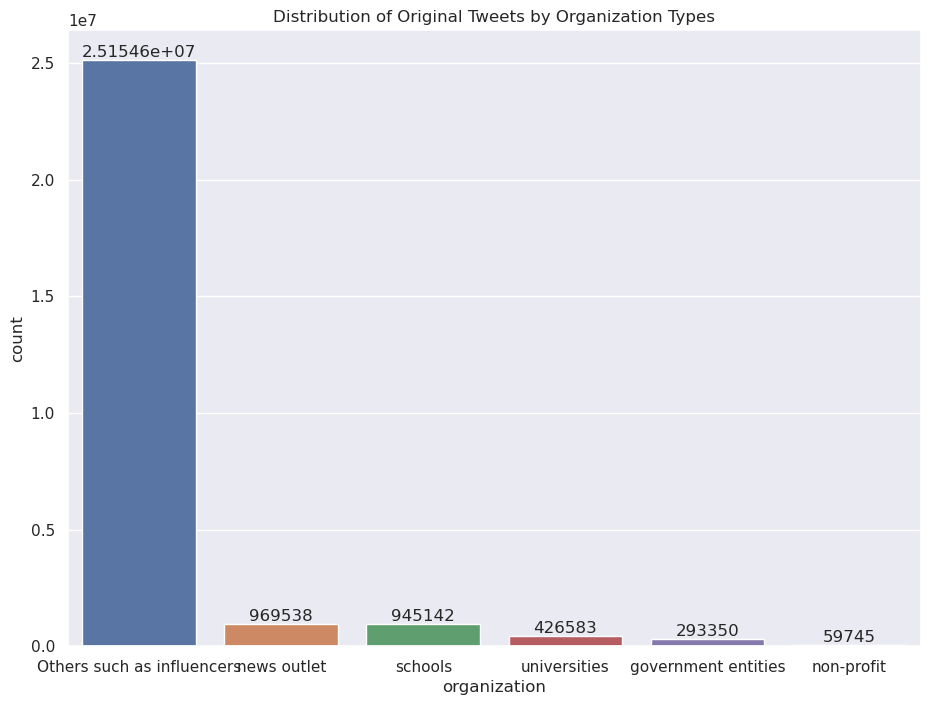

In [21]:
### visualization the original tweet amount by organization type
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = org_v['organization'], y = org_v['count'])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title='Distribution of Original Tweets by Organization Types')

[Text(0.5, 1.0, 'Distribution of Original Tweets by Organization Types (Related Tweets)')]

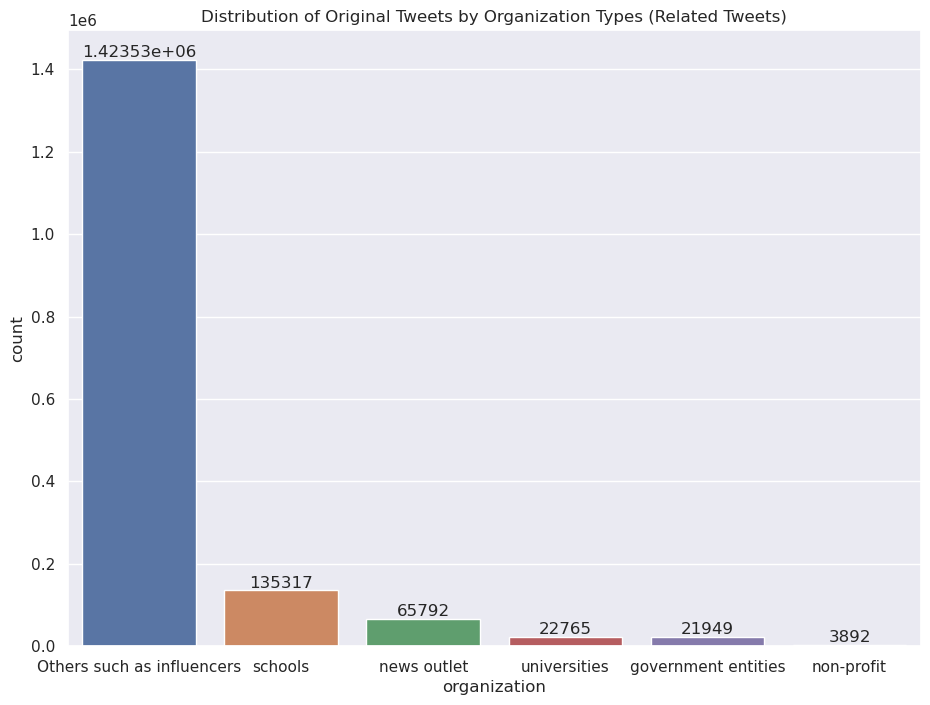

In [93]:
### visualization the original tweet amount by organization type (related tweets)
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = org_v_related_df['organization'], y = org_v_related_df['count'])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title='Distribution of Original Tweets by Organization Types (Related Tweets)')

[Text(0.5, 1.0, 'Retweets Amout by Organization Types')]

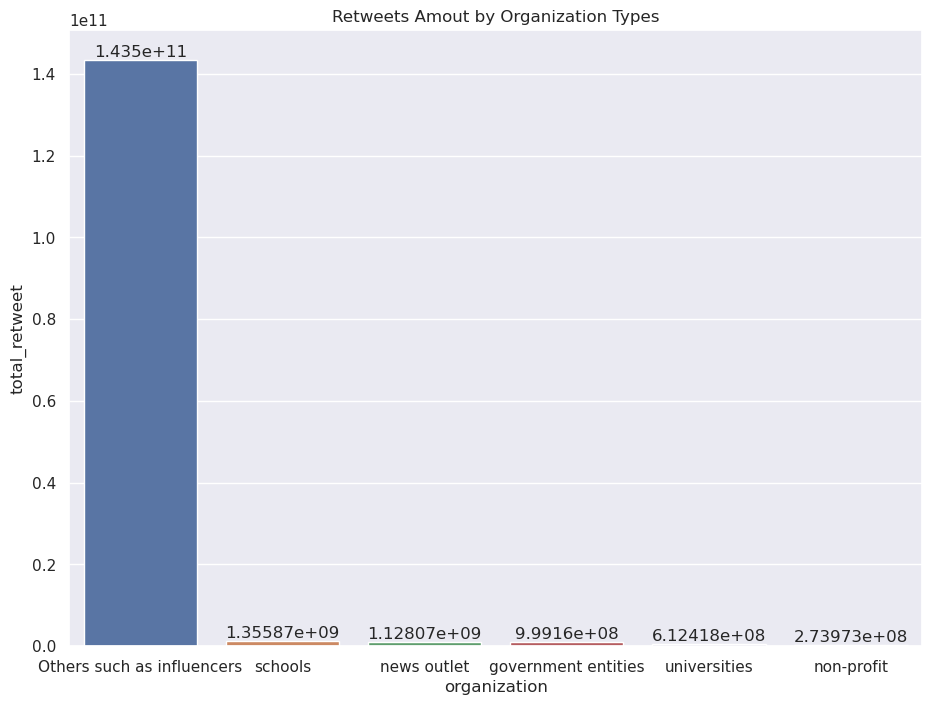

22/12/05 09:48:16 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670230743573_0001_01_000049 on host: hub-msca-bdp-dphub-students-kaitongh-sw-kshw.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-05 09:48:16.549]Container killed on request. Exit code is 143
[2022-12-05 09:48:16.550]Container exited with a non-zero exit code 143. 
[2022-12-05 09:48:16.561]Killed by external signal
.
22/12/05 09:48:16 ERROR org.apache.spark.scheduler.cluster.YarnScheduler: Lost executor 49 on hub-msca-bdp-dphub-students-kaitongh-sw-kshw.c.msca-bdp-students.internal: Container from a bad node: container_1670230743573_0001_01_000049 on host: hub-msca-bdp-dphub-students-kaitongh-sw-kshw.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-05 09:48:16.549]Container killed on request. Exit code is 143
[2022-12-05 09:48:16.550]Container exited with a non-zero exit code 143. 
[2022-12-05 09:48:16.561]Killed by external signal
.
22/12/

In [22]:
### visualization the retweet amount by organization type
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = org_retweeted['organization'], y = org_retweeted['total_retweet'])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title='Retweets Amout by Organization Types')

[Text(0.5, 1.0, 'Retweets Amout by Organization Types (Related Tweets)')]

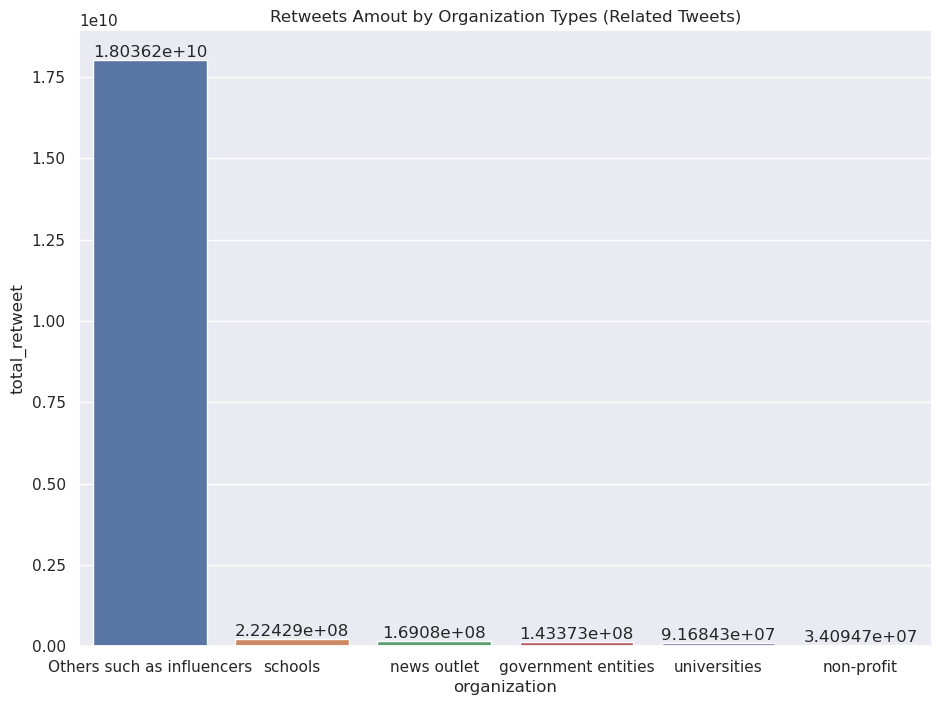

In [96]:
### visualization the retweet amount by organization type
sns.set(rc={'figure.figsize':(11,8)})
ax = sns.barplot(x = org_retweeted_related_df['organization'], y = org_retweeted_related_df['total_retweet'])
for i in ax.containers:
    ax.bar_label(i,)
    
ax.set(title='Retweets Amout by Organization Types (Related Tweets)')

### Where are these Twitterers (all of them, not just influencers) located?
##### Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?
##### Visualize the geographical distribution

##### Topic chosen: “critical race theory” 
##### URL: https://www.edweek.org/policy-politics/map-where-critical-race-theory-is-under-attack/2021/06

In [12]:
related_df.count()

8546375

In [18]:
related_df.limit(10)

created_at,tweet_id,tweet_text,user_id,user_name,user_screen_name,user_location,user_description,tweet_country,tweet_location,retweeted_status.retweet_count,retweeted_from,retweeted,favorite_count,timestamp_ms,cleaned_location
Tue Jun 28 12:43:...,1541764324217090048,if muslim teacher...,701170369466658818,Fer Coach Davis,Ferdavis9113,"Buffalo Grove, IL",You only get bett...,null,null,8936,ReallyAmerican1,RT,0,1656420234146,Buffalo Grove
Tue Jun 28 12:43:...,1541764345243308036,the so-called “su...,2627600063,rochu,_rosemarieh,"Buenos Aires, Arg...",Al binarismo no v...,null,null,36647,JoJoFromJerz,RT,0,1656420239159,Buenos Aires
Tue Jun 28 12:43:...,1541764346493157380,@ilhanmn i agree....,820311311112433665,Karen,Kaystuff66,Blue,Caregiver 2 USArm...,null,null,2,Laura_N_Pittman,RT,0,1656420239457,Blue
Tue Jun 28 12:44:...,1541764355695460354,"so, let me get th...",1250844681530998793,George Migs,GeorgeMigliacc1,null,"Enjoying Life , A...",null,null,997,Logically_JC,RT,0,1656420241651,null
Tue Jun 28 12:44:...,1541764360510574593,scotus just ruled...,1163052939528699904,Jeff Field,JeffField18,null,null,null,null,14196,QasimRashid,RT,0,1656420242799,null
Tue Jun 28 12:44:...,1541764365422014465,"sir,neet ug has i...",1298164597631750144,Dibyajyoti Mandal,DibyajyotiMan13,null,null,null,null,15,dentodontics,RT,0,1656420243970,null
Tue Jun 28 12:44:...,1541764380907278337,east coast mall p...,590051081,♌︎h𝔸𝔼ℝ𝕀meowᵃᵉ,harimeow_,Sri Aman Sarawak,🌙 fruity meow | G,null,null,410,wawabahurdin,RT,0,1656420247662,Sri Aman Sarawak
Tue Jun 28 12:44:...,1541764382954123264,the supreme court...,723669941472223232,big dog E,eschmi56,null,He/They Middle Te...,null,null,3565,IlhanMN,RT,0,1656420248150,null
Tue Jun 28 12:44:...,1541764397281968129,looking for a han...,1314192392535375872,Thistleflat Crafts,thistleflat,"Co Durham, UK",Sarah (she/her) H...,null,null,7,woodenyoulove,RT,0,1656420251566,Co Durham
Tue Jun 28 12:44:...,1541764405272219648,scotus just ruled...,1311295591369113600,Eric Fortess,EricFortess,null,Road worrier.,null,null,14198,QasimRashid,RT,0,1656420253471,null


In [84]:
related = related_df.groupby('cleaned_location').count().sort(desc(count("cleaned_location"))).limit(20).toPandas()

In [85]:
related

,cleaned_location,count
0,United States,133850
1,Texas,66521
2,London,55883
3,New York,55722
4,USA,54321
5,California,54190
6,Florida,53466
7,Los Angeles,41060
8,Washington,40660
9,Chicago,35350


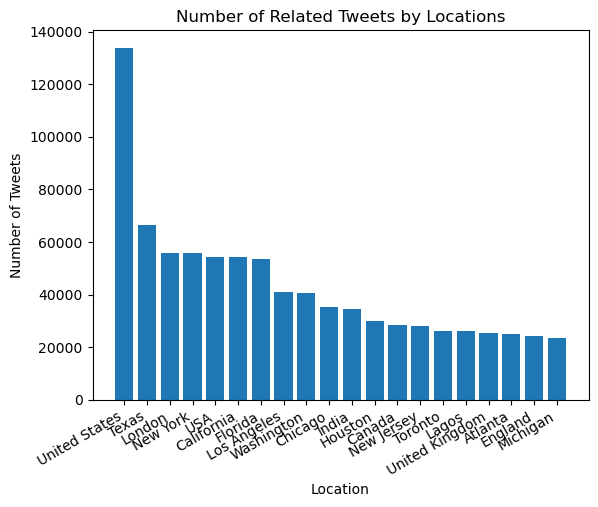

In [29]:
x = related["cleaned_location"]
y = related["count"]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Location')
plt.title('Number of Related Tweets by Locations')
plt.xticks(rotation=30, ha='right')
plt.show()

### What are the timelines of these tweets? Do you see significant peaks and valleys?
##### Do you see any data collection gaps?
##### Plot the timelines of these tweets

In [28]:
df.limit(5)

created_at,tweet_id,tweet_text,user_id,user_name,user_screen_name,user_location,user_description,tweet_country,tweet_location,retweeted_cnt,retweeted_from,retweeted,favorite_count,timestamp_ms,Organization,date,month_year
Fri Apr 29 13:50:...,1520037774149054464,do you have a stu...,2859364768,Saint Regis Mohaw...,srm_tribe,"Akwesasne, NY",Saint Regis Mohaw...,null,null,null,null,,0,1651240220950,Others such as in...,Apr 29 2022,Apr 2022
Fri Apr 29 13:50:...,1520037774988124162,school crush ...,1069954156029464577,ً,gguktth,judy p smp,nao chegue perto ...,null,null,2178,bchanarchive,RT,0,1651240221150,Others such as in...,Apr 29 2022,Apr 2022
Fri Apr 29 13:50:...,1520037774929321985,face head writer ...,1459266333074407424,Dodie,Dodie05301739,null,null,null,null,null,null,,0,1651240221136,Others such as in...,Apr 29 2022,Apr 2022
Fri Apr 29 13:50:...,1520037775449415680,@curtlafond @free...,1157856958864592901,AW 🛡️,LogosIsBond,null,Defilement is fro...,null,null,null,FreeStateNH Why a...,,0,1651240221260,Others such as in...,Apr 29 2022,Apr 2022
Fri Apr 29 13:50:...,1520037775868899328,"ethiopian, amhara...",1501662738837381122,Brhan tigray !!💟,brhanlove3,null,#500DaysOfTigrayG...,null,null,null,null,,0,1651240221360,Others such as in...,Apr 29 2022,Apr 2022


In [29]:
df.agg(countDistinct('date')).limit(20)

count(date)
216


In [22]:
### figuring out the total number of tweets posted each date 
timeline = related_df.groupby('date').agg(count('tweet_id').alias('num_of_tweets')).toPandas()

In [20]:
### converting the date column to date type 
timeline['date'] = timeline['date'].astype('datetime64[ns]')

[Text(0.5, 1.0, 'Total Number of Tweets Posted Per Day')]

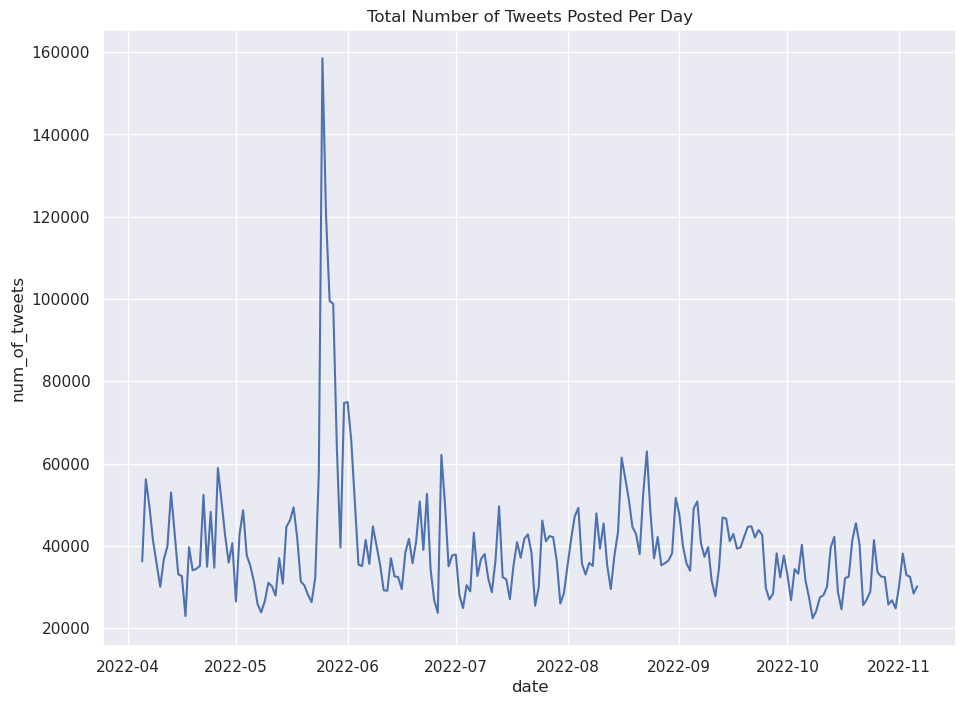

In [21]:
sns.set(rc={'figure.figsize':(11,8)})
sns.lineplot(x = timeline['date'], y = timeline['num_of_tweets']).set(title = 'Total Number of Tweets Posted Per Day')

### How unique are the messages?
##### Are they mostly unique? Or usually people are just copy-pasting the same text?
##### You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
##### Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)
##### Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis

In [15]:
related_df.limit(5)

created_at,tweet_id,tweet_text,user_id,user_name,user_screen_name,user_location,user_description,tweet_country,tweet_location,retweeted_cnt,retweeted_from,retweeted,favorite_count,timestamp_ms,Organization,date,month_year,cleaned_location
Thu Apr 14 14:59:...,1514619361814024200,a teacher of a go...,2334729752,Bagath_Singh 2.0🇮🇳,bagathsingh_TN,null,(Article 1- India...,null,null,3403,AskAnshul,RT,0,1649948370780,Others such as in...,Apr 14 2022,Apr 2022,null
Thu Apr 14 14:59:...,1514619362459930627,✨privet✨ bunts sa...,1263449952447074313,Bunts Sangha’s S....,smshettycollege,"Powai, Mumbai",The Official Twit...,null,null,null,null,,0,1649948370934,Others such as in...,Apr 14 2022,Apr 2022,Powai
Thu Apr 14 14:59:...,1514619365504684047,1. the education ...,927606780,pereda demam,baybyefever,"DKI Jakarta, Indo...",Please say hi first!,null,null,1497,NewsBFM,RT,0,1649948371660,Others such as in...,Apr 14 2022,Apr 2022,DKI Jakarta
Thu Apr 14 14:59:...,1514619366372896780,a teacher of a go...,1394940630254632960,Mahi Singh,MahiSin93966366,null,null,null,null,3404,AskAnshul,RT,0,1649948371867,Others such as in...,Apr 14 2022,Apr 2022,null
Thu Apr 14 14:59:...,1514619369124347910,pro-democracy cdm...,1437280912668913667,Nyeinhk,Nhk19921,United States,I'm here to tweet...,null,null,15,ActivistLittle,RT,0,1649948372523,Others such as in...,Apr 14 2022,Apr 2022,United States


In [16]:
text_org = related_df.select(['tweet_text', 'Organization'])

In [17]:
text_org.limit(10)

tweet_text,Organization
@harrisfaulkner i...,Others such as in...
@boiboi504jon @li...,schools
completely in awe...,Others such as in...
i just spoke with...,Others such as in...
completely in awe...,news outlet
completely in awe...,Others such as in...
completely in awe...,Others such as in...
#qhes teachers pl...,Others such as in...
completely in awe...,Others such as in...
@favoriteteach11 ...,Others such as in...


In [38]:
### setting up helper function 

def hashed_df(text_sample_raw):
    text_sample = text_sample_raw.rdd.map(lambda x : x['tweet_text']).filter(lambda x: x is not None)
    
    StopWords = stopwords.words("english")

    text_tokens = text_sample\
        .map( lambda document: document.strip().lower())\
        .map( lambda document: re.split(" ", document))\
        .map( lambda word: [x for x in word if x.isalnum()])\
        .map( lambda word: [x for x in word if len(x) > 3] )\
        .map( lambda word: [x for x in word if x not in StopWords])\
        .zipWithIndex()
    
    row = Row('tweet_text')
    text_df = text_sample.map(row).zipWithIndex().toDF(['tweet_text','id'])
    
    df_text_tokens = spark.createDataFrame(text_tokens, ["title_list_of_words",'id'])

    #Drop records with no tokens
    df_text_tokens = df_text_tokens.where(col('title_list_of_words').getItem(0).isNotNull())
    
    vectorize_text = CountVectorizer(inputCol="title_list_of_words", outputCol="features", minDF=1.0)
    df_vectorize_text = vectorize_text.fit(df_text_tokens).transform(df_text_tokens)
    
    mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
    model = mh.fit(df_vectorize_text)
    df_hashed = mh.fit(df_vectorize_text).transform(df_vectorize_text).cache()
    
    df_hashed_text = text_df.join(df_hashed, "id", how = 'left').cache()
    
    return model, df_hashed_text



def get_duplicate(model, df_hashed_text, distance):
    
    jaccard_distance = distance
    
    df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )
    
    df_dups = df_dups_text
    
    records = df_hashed_text.count()
    dups = df_dups_text.select('id_A').distinct().count()
    uniques = records - dups

    print ('Total records: ', records)
    print ('Duplicate titles based on {', jaccard_distance, '} jaccard distance: ', dups)
    print ('Unique titles based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)
    
    dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

    ax = dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
    ax.set_title('Text duplication analysis: Jaccard Distance {}'.format(distance), fontsize=15)
    for p in ax.patches:
           ax.annotate(format(p.get_height(), '.1f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points') 
            
def compare_dups(model, df_hashed_text, d_1, d_2, d_3):
    df_dups_30 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, d_1).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B')) 
    
    df_dups_50 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, d_2).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B')) 
    
    df_dups_70 = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, d_3).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.tweet_text').alias('tweet_text_A'),
            col('datasetB.tweet_text').alias('tweet_text_B'))   
    
    df_dups_30_id = df_dups_30.select(col('id_A').alias('id_30_A'), col('id_B').alias('id_30_B'))
    df_dups_50_id = df_dups_50.select(col('id_A').alias('id_50_A'), col('id_B').alias('id_50_B'))
    df_dups_70_id = df_dups_70.select(col('tweet_text_A'), col('tweet_text_B'),\
                                  col('id_A').alias('id_70_A'), col('id_B').alias('id_70_B'))
    
    dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
        .join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")
    
    dups_combined = dups_combined.\
        withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
        withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
        withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
        drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')
    
    dups_combined_sample = \
        dups_combined.filter(("threshold_30 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10).\
        union\
        (dups_combined.filter(("threshold_30 == 'Non-Dup' and threshold_50 == 'Duplicate'")).sample(False, 0.1, 12345).limit(10)).\
        union\
        (dups_combined.filter(("threshold_50 == 'Non-Dup'")).sample(False, 0.1, 12345).limit(10)).\
        orderBy('threshold_30', 'threshold_50', 'threshold_70')
    
    pd.set_option('display.max_rows', 30)
    return dups_combined_sample.toPandas()

#### for all organization types 

In [46]:
text_sample_raw = text_org.sample(0.0005).limit(3000)

In [48]:
text_sample_raw.count()

3000

In [49]:
model, df_hashed_text = hashed_df(text_sample_raw)

##### jaccard distance 0.3

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  406
Unique titles based on { 0.3 } jaccard distance:  0.3 :  2594


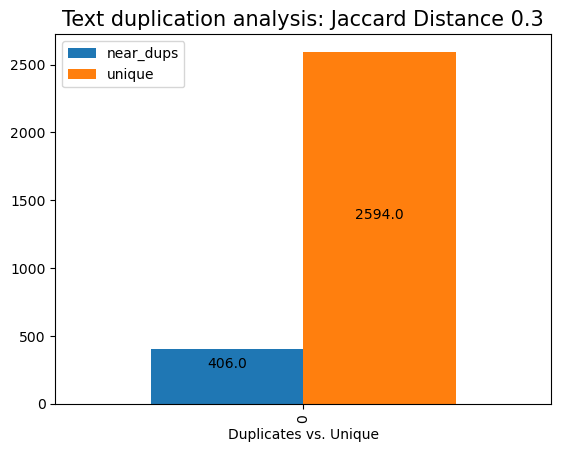

In [51]:
get_duplicate(model, df_hashed_text, 0.3)

##### jaccard distance 0.5

Total records:  3000
Duplicate titles based on { 0.5 } jaccard distance:  419
Unique titles based on { 0.5 } jaccard distance:  0.5 :  2581


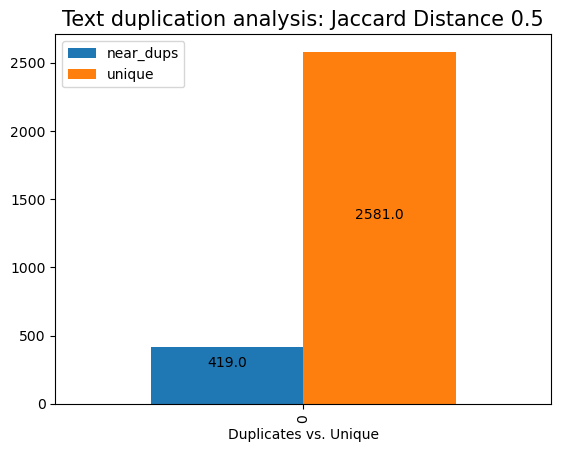

In [52]:
get_duplicate(model, df_hashed_text, 0.5)

##### jaccard distance 0.7

Total records:  3000
Duplicate titles based on { 0.7 } jaccard distance:  600
Unique titles based on { 0.7 } jaccard distance:  0.7 :  2400


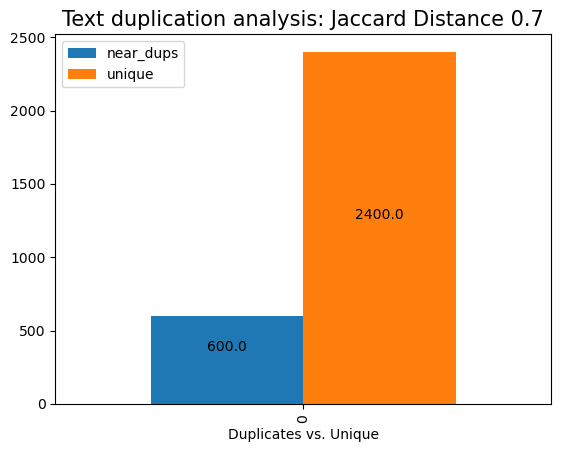

In [53]:
get_duplicate(model, df_hashed_text, 0.7)

##### comparison

In [54]:
compare_dups(model, df_hashed_text, 0.3, 0.5, 0.7)

,tweet_text_A,tweet_text_B,threshold_30,threshold_50,threshold_70
0,"(not a conservative, never have been, voting against democrats for the foreseeable future. why?\n\nlockdowns, masks, school closures, quarantine camps, curfews, inflation, crime, guns, taxes, the woke, sexualizing kids, green energy, social credit scores, censorship, general bigotry,)","(@brooks_of_green @macnelious100 @itgirljaylaan again, you can drink whatever you want. learning in schools? they only set a curriculum, teachers and the schools themselves ultimately choose what to teach. where we can drive, you can drive anywhere as long as its not private property, which the property owner enforces, (2/?),)",Duplicate,Duplicate,Duplicate
1,"(how is it radical to think billionaires should pay a higher tax rate than school teachers?,)","(romford man fights off men in park to 'save two school girls from sexual assault' https://t.co/1vcmghmyhp,)",Duplicate,Duplicate,Duplicate
2,"(high school teacher video https://t.co/m2aekoeuol,)","(at least 181 school employees have been arrested for child sex crimes this year. that's an average of one per day. \nhttps://t.co/csp4w5y2ym,)",Duplicate,Duplicate,Duplicate
3,"(children were locked out of school for 10 days at a time if even in the same classroom as a positive person, but the vp can hug someone after spending time with covid-positive potus.\n\nonly kids are treated as viral vectors while adults live normally. \n\nhttps://t.co/2dot1fn0oi,)","(@evilmopacatx @dougjballoon in this austin diner (magnolia cafe), a state government employee and an elementary school teacher wondered if they could purchase a starter home that had a little more space in the neighborhood. luckily, they found this new listing today. https://t.co/b6kkbh5p9f,)",Duplicate,Duplicate,Duplicate
4,"(hi my name is cora wife, mom of 4 and sped parapro. i just found i’m moving up to 4th grade sped classroom this upcoming school year. i have basic supplies, snacks, and games. please check out my @amazon #wishlist #clearthelist https://t.co/7j9jpxk5zq https://t.co/uvq1bwwnr4,)","(critical race theory is not taught in elementary/ middle schools. that’s gop bugaboo.\nthe mere mention, and poof! gone! voodoo!\n\n“all of the political benefit; none of the administrative legwork”\n\nstop gop abracadabra!\n\n#wtpblue #onev1 #demvoice1 #fresh https://t.co/ycnymjldsf,)",Duplicate,Duplicate,Duplicate
5,"(unlike jd vance, @timryan will fully fund our public schools and support our teachers. getting out the jewish vote in ohio will help ensure tim ryan defeats jd vance’s regressive agenda.,)","(no. they want all students, especially those trapped in crappy schools with crappier teachers by the vea and democrats, to have a chance at going to a good school. even the best school.\n\nwhy do you oppose money following the child? i don't get it.,)",Duplicate,Duplicate,Duplicate
6,"(dagger parivaar school is for specially abled children, who require significant physical interaction including facial interpretation of subjects being taught with lots of love.relation between teacher &amp; student is more of mother&amp; child than of a preacher&amp; followers. ask parents!,)","(@cardboarddreaml thank you! high school science teacher trying to get laminating sheets (we use so many!) or gift cards towards a dissection kit for a record number of students taking bio this year. anything helps- thanks! #clearthelist https://t.co/rlhrsxxtfo https://t.co/kljuat0zcu,)",Duplicate,Duplicate,Duplicate
7,"(hi @ambermac \ni am a second grade inclusion teacher in ny. would you consider helping us #clearthelist with a sprinkle or retweet? schools cannot supply teachers with everything we need for amazing experiences. please help us with a sprinkle or rt.🤍\nhttps://t.co/aahqc9ufhr https://t.co/592da9jsmf,)","(finally found the “giving out free drugs” guy that all our middle school teachers warned us about…fuck yea,)",Duplicate,Duplicate,Duplicate
8,"(@evilmopacatx @dougjballoon in this austin

#### For Government entities

In [33]:
text_org.groupby('Organization').count()

Organization,count
schools,414870
Others such as in...,7802431
universities,74060
non-profit,14430
news outlet,141385
government entities,99199


In [55]:
gov_sample_raw = text_org.filter(text_org.Organization == 'government entities').sample(0.05).limit(3000)

In [56]:
gov_sample_raw.count()

3000

In [57]:
gov_model, df_hashed_gov = hashed_df(gov_sample_raw)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  350
Unique titles based on { 0.3 } jaccard distance:  0.3 :  2650


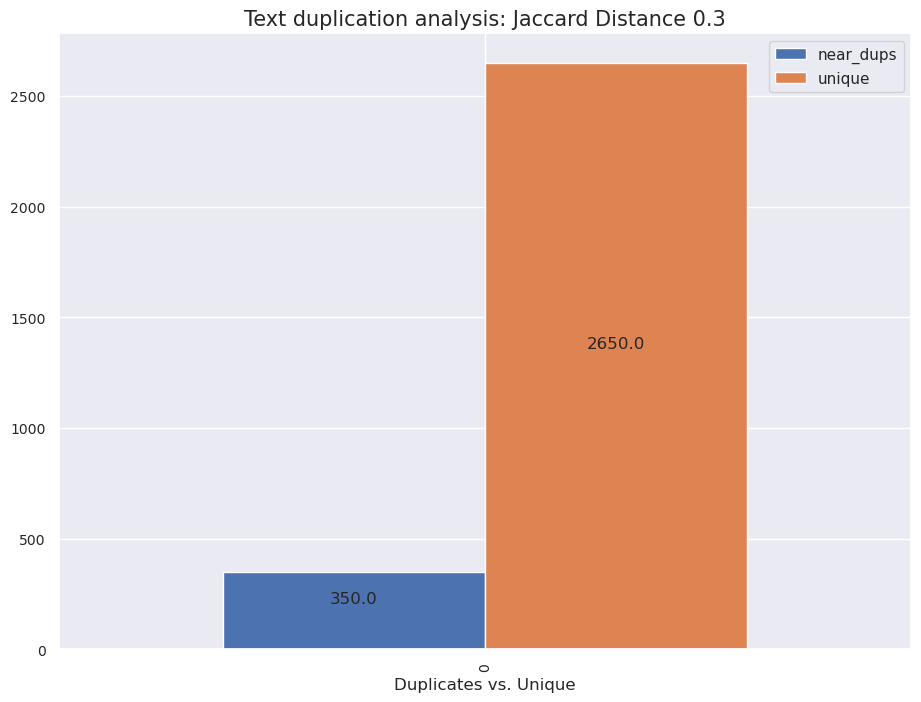

In [106]:
get_duplicate(gov_model, df_hashed_gov, 0.3)

#### For Universities

In [60]:
uni_sample_raw = text_org.filter(text_org.Organization == 'universities').sample(0.06).limit(3000)

In [61]:
uni_sample_raw.count()

3000

In [62]:
uni_model, df_hashed_uni = hashed_df(uni_sample_raw)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  346
Unique titles based on { 0.3 } jaccard distance:  0.3 :  2654


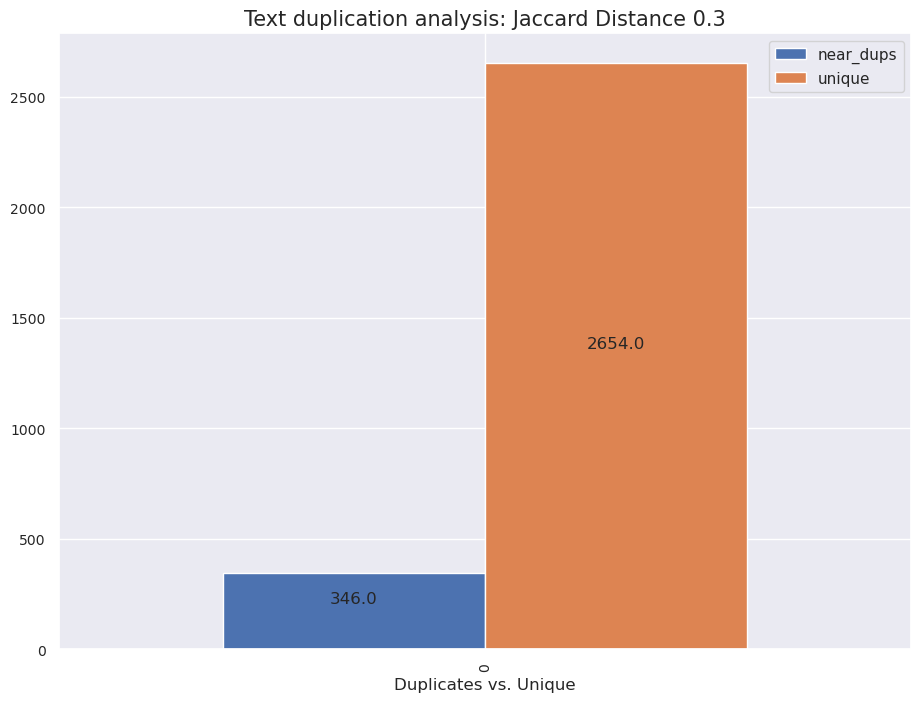

In [105]:
get_duplicate(uni_model, df_hashed_uni, 0.3)

#### For Schools

In [65]:
schools_sample_raw = text_org.filter(text_org.Organization == 'schools').sample(0.02).limit(3000)

In [66]:
schools_sample_raw.count()

3000

In [67]:
schools_model, df_hashed_schools = hashed_df(schools_sample_raw)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  230
Unique titles based on { 0.3 } jaccard distance:  0.3 :  2770


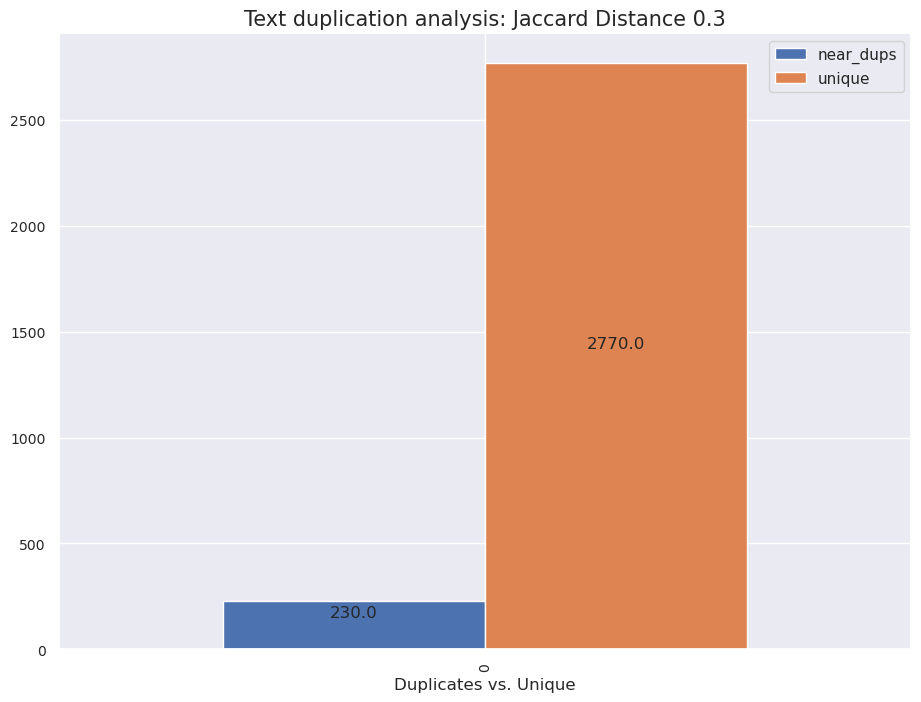

In [104]:
get_duplicate(schools_model, df_hashed_schools, 0.3)

#### For non-profit

In [70]:
np_sample_raw = text_org.filter(text_org.Organization == 'non-profit').sample(0.5).limit(3000)

In [74]:
np_sample_raw.count()

3000

In [72]:
np_model, df_hashed_np = hashed_df(np_sample_raw)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  454
Unique titles based on { 0.3 } jaccard distance:  0.3 :  2546


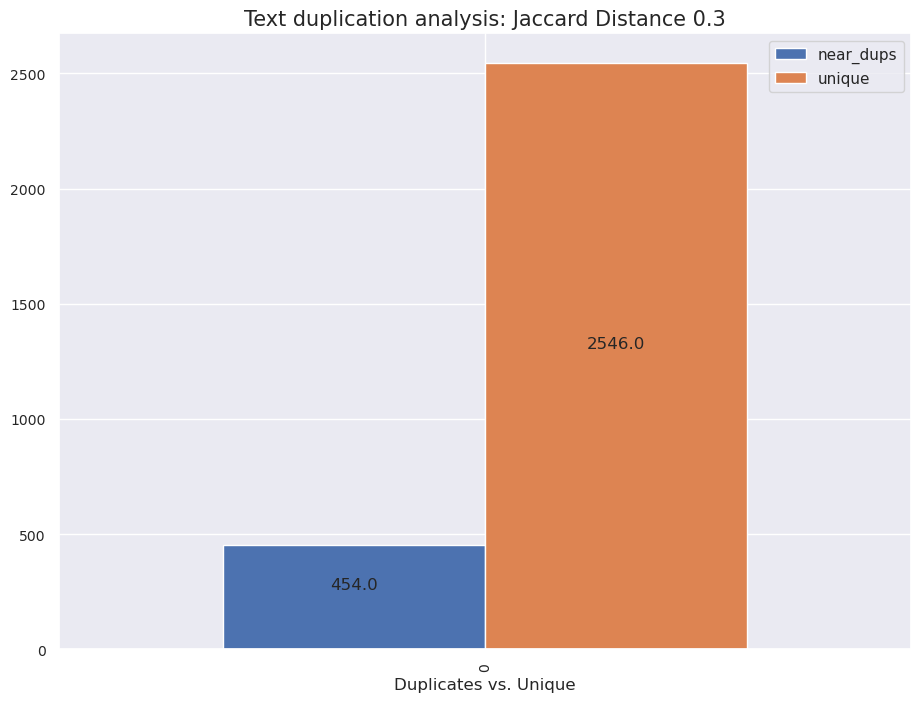

In [103]:
get_duplicate(np_model, df_hashed_np, 0.3)

#### for news outlets

In [97]:
news_sample_raw = text_org.filter(text_org.Organization == 'news outlet').sample(0.1).limit(3000)

In [98]:
news_sample_raw.count()

3000

In [99]:
news_model, df_hashed_news = hashed_df(news_sample_raw)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  217
Unique titles based on { 0.3 } jaccard distance:  0.3 :  2783


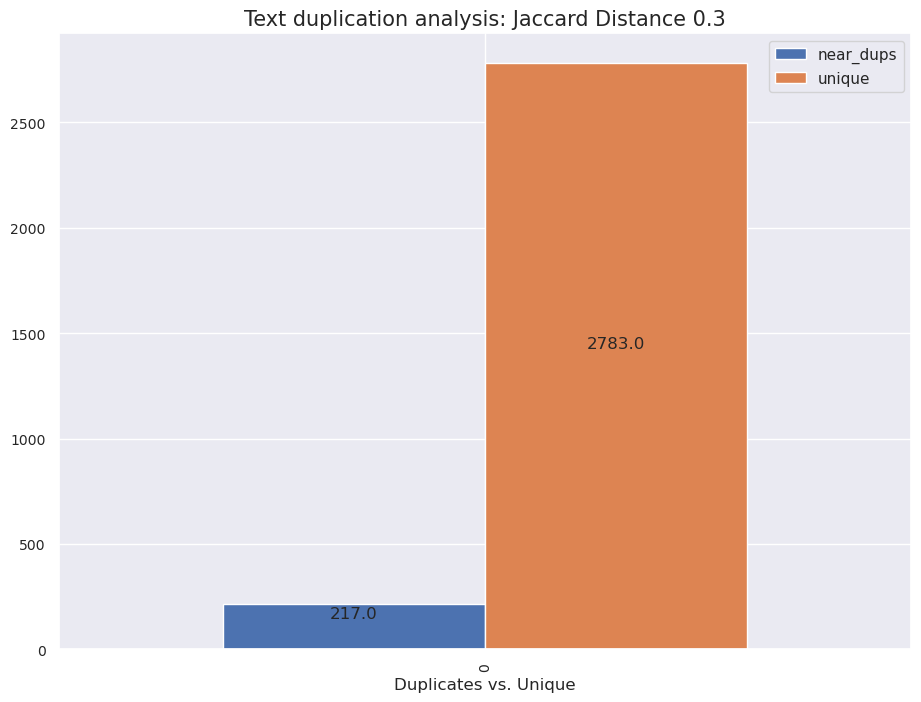

In [101]:
get_duplicate(news_model, df_hashed_news, 0.3)

#### For Others such as influencers

In [80]:
influencers_sample_raw = text_org.filter(text_org.Organization == 'Others such as influencers').sample(0.001).limit(3000)

In [81]:
influencers_sample_raw.count()

3000

In [82]:
influencers_model, df_hashed_influencers = hashed_df(influencers_sample_raw)

Total records:  3000
Duplicate titles based on { 0.3 } jaccard distance:  420
Unique titles based on { 0.3 } jaccard distance:  0.3 :  2580


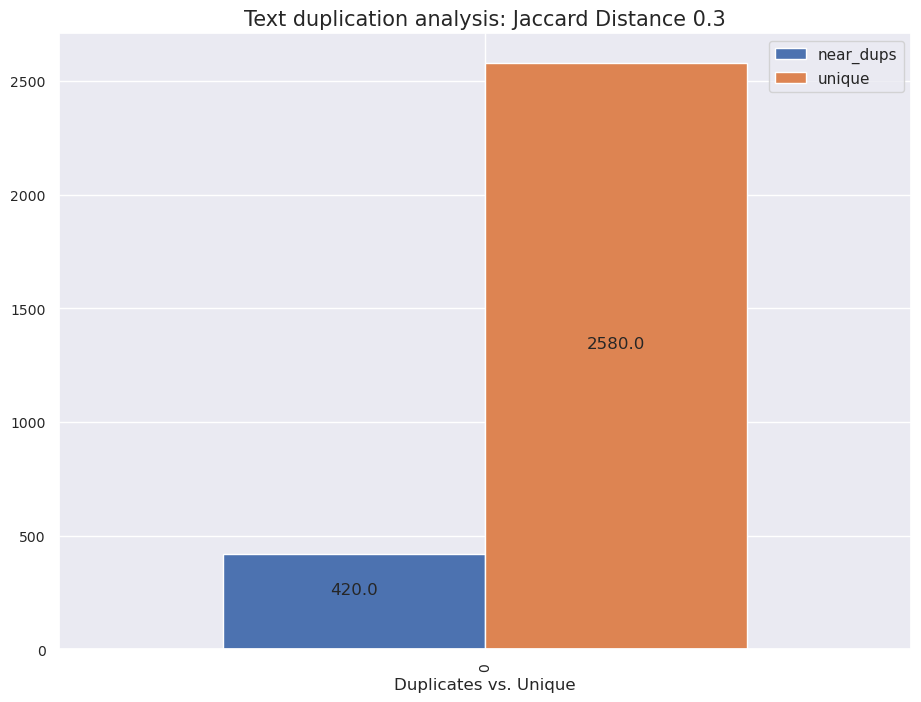

In [102]:
get_duplicate(influencers_model, df_hashed_influencers, 0.3)